# GERMAN CREDIT MODELING

### - Decision Tree
### - Gradient Boosting
### - Random Forest
### - Logistic Regression

In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [603]:
df = pd.read_csv('~/Documents/My Samples/germancredit.csv',header=0)

In [604]:
# Metadata
md = pd.read_csv('~/Documents/My Samples/GermanCreditMetaData.csv',header=0,index_col='Code')
md['Ord Meaning'] = md.index + ' ' + md.Meaning
mdmap = md['Ord Meaning'].to_dict()

## Data Transformations

In [605]:
df['bad'] = df.pop('GoodCredit') - 1

# New Feature: Age Group (Nominal)
df['age_group'] =  pd.cut(df.age13,[18,25,30,50,60,90])

In [606]:
v_nominal = list(df.select_dtypes(include='O').columns)
nominal = v_nominal + ['age_group'] + ['installment8','residence11','liable18']

df = pd.get_dummies(df, columns=nominal, drop_first=True)
df.shape

(1000, 57)

In [607]:
predictors = df.drop('bad',axis=1).columns
print(*sorted(predictors),sep='\t')

age13	age_group_(25, 30]	age_group_(30, 50]	age_group_(50, 60]	age_group_(60, 90]	amount5	cards16	checkingstatus1_A12	checkingstatus1_A13	checkingstatus1_A14	duration2	employ7_A72	employ7_A73	employ7_A74	employ7_A75	foreign20_A202	history3_A31	history3_A32	history3_A33	history3_A34	housing15_A152	housing15_A153	installment8_2	installment8_3	installment8_4	job17_A172	job17_A173	job17_A174	liable18_2	otherplans14_A142	otherplans14_A143	others10_A102	others10_A103	property12_A122	property12_A123	property12_A124	purpose4_A41	purpose4_A410	purpose4_A42	purpose4_A43	purpose4_A44	purpose4_A45	purpose4_A46	purpose4_A48	purpose4_A49	residence11_2	residence11_3	residence11_4	savings6_A62	savings6_A63	savings6_A64	savings6_A65	status9_A92	status9_A93	status9_A94	tele19_A192


In [608]:
from sklearn.preprocessing import StandardScaler

np.random.seed(2018)
rng = np.random.sample(len(df))

X_train = df.loc[rng < 0.6, predictors]
y_train = df.loc[rng < 0.6, 'bad']
X_test  = df.loc[rng >= 0.6, predictors]
y_test  = df.loc[rng >= 0.6, 'bad']

scaler = StandardScaler()
scaler.fit(X_train.values.astype('float'))

X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

## Decision Tree Classifier

In [609]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30,
                           min_impurity_decrease=.0001,
                           random_state=18)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_test)[:, 1]
y_est_dt  = dt.predict_proba(X_train)[:, 1]

print('DTree Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_dt),
    roc_auc_score(y_test, y_pred_dt)))

DTree Training AUC = 77.37%       Validation AUC = 76.48%


Predictors in Model 9

Feature Imporances (Top Predictors)


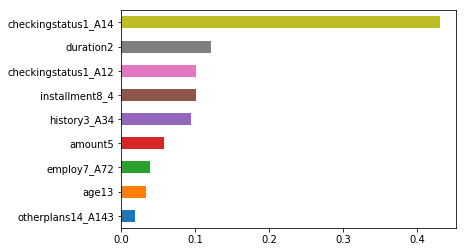

In [610]:
fi = pd.Series(dt.feature_importances_,index=predictors)
fi = fi[fi>0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi.sort_values().plot.barh()

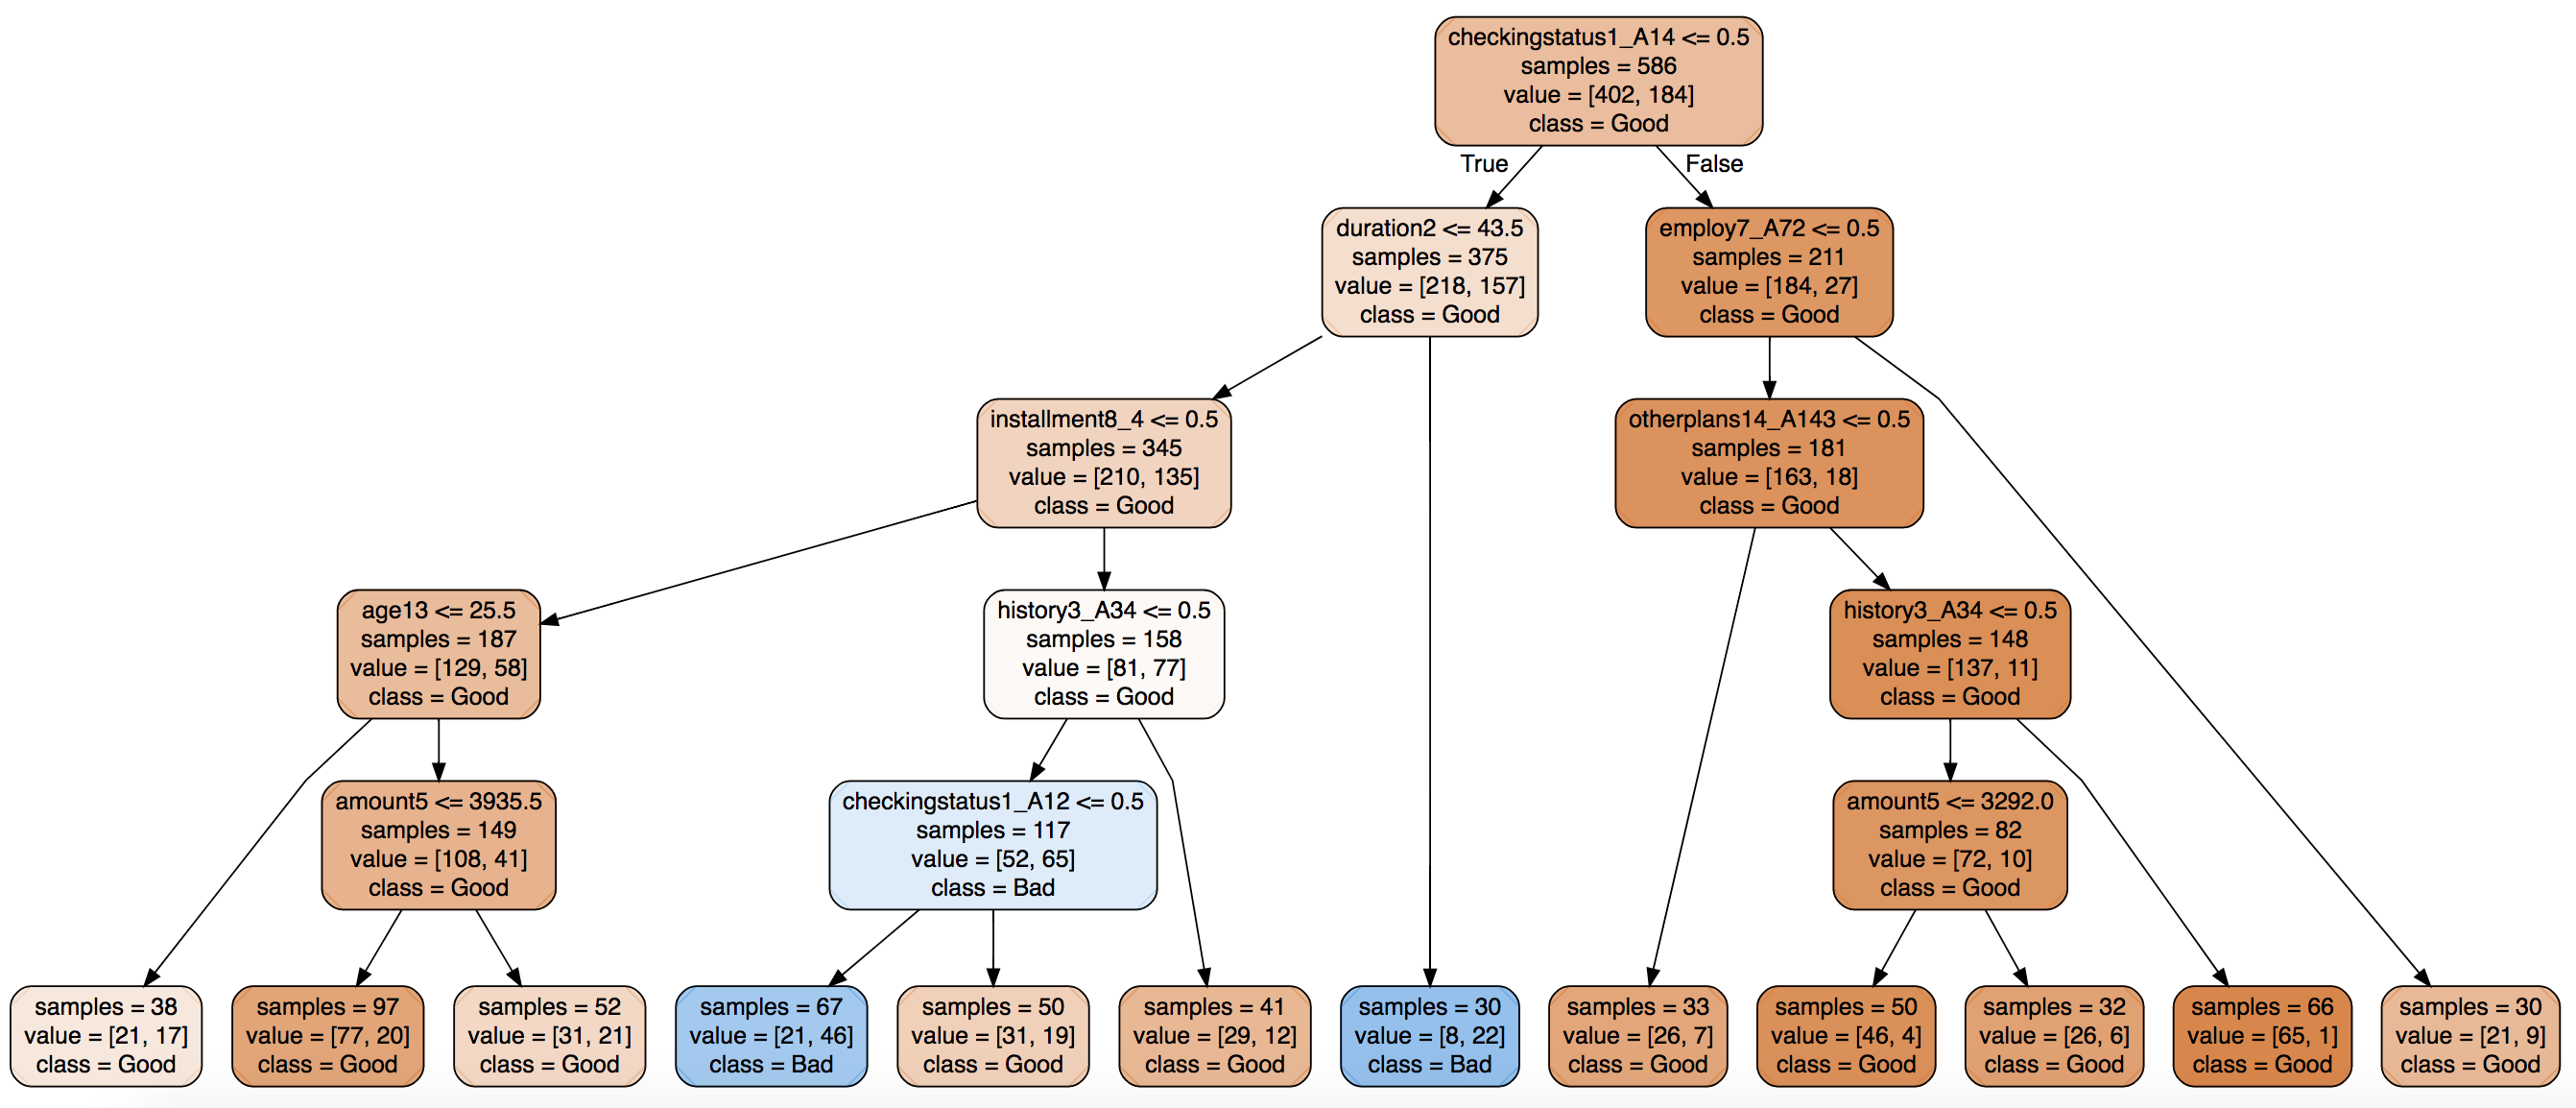

In [611]:
from sklearn.tree import export_graphviz
from IPython.display import Image

tree_graph = export_graphviz(dt,out_file=None,                              
    impurity = False,
    leaves_parallel=True,
    feature_names = predictors,
    class_names = ['Good', 'Bad'],
    rounded = True,
    filled= True )
#print(tree_graph)
Image("../GermanCredit/GermanCreditDTree.png")

## Gradient Boosting Tree

### Non Trivial Stump

In [612]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

grd = GradientBoostingClassifier(max_leaf_nodes=8,learning_rate=0.001,
            n_estimators=3000,subsample=.5, min_samples_leaf=20,
                                 random_state=18)
grd.fit(X_train, y_train)

y_pred_grd = grd.predict_proba(X_test)[:, 1]
y_est_grd  = grd.predict_proba(X_train)[:, 1]

print('GBM Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_grd),
    roc_auc_score(y_test, y_pred_grd)))

GBM Training AUC = 89.18%       Validation AUC = 79.49%


Predictors in Model 47

Feature Imporances (Top Predictors)


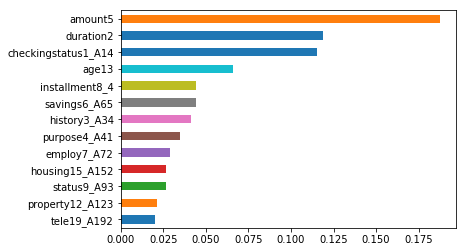

In [613]:
fi = pd.Series(grd.feature_importances_,index=predictors)
fi = fi[fi>0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.02].sort_values().plot.barh()

### Trivial Stump

In [614]:
from sklearn.ensemble import AdaBoostClassifier

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=10)
#dt_stump.fit(X_train_std, y_train)

ada = AdaBoostClassifier(base_estimator=dt_stump,n_estimators=1000,
                         algorithm="SAMME",random_state=18)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict_proba(X_test)[:, 1]
y_est_ada  = ada.predict_proba(X_train)[:, 1]

print('ADA   Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_ada),
    roc_auc_score(y_test, y_pred_ada)))

ADA   Training AUC = 83.32%       Validation AUC = 78.52%


Predictors in Model 45

Feature Imporances (Top Predictors)


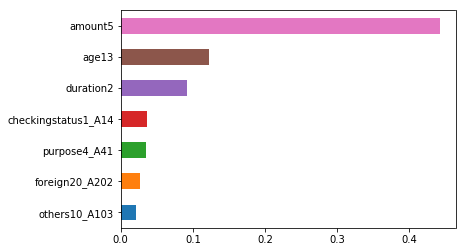

In [615]:
fi = pd.Series(ada.feature_importances_,index=predictors)
fi = fi[fi>0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.02].sort_values().plot.barh()

## Random Forest

In [616]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,max_depth=6,min_samples_leaf=10,
                           random_state=18)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_est_rf  = rf.predict_proba(X_train)[:, 1]

print('Random Forest Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_rf),
    roc_auc_score(y_test, y_pred_rf)))

Random Forest Training AUC = 89.10%       Validation AUC = 79.19%


Predictors in Model 53

Feature Imporances (Top Predictors)


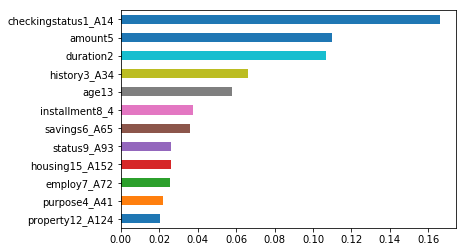

In [617]:
fi = pd.Series(rf.feature_importances_,index=predictors)
fi = fi[fi>0.0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.02].sort_values().plot.barh()

## Logistic Regression

### Logistic Regression: As if Machine Learning

In [618]:
from sklearn.linear_model import LogisticRegression


# Set regularization parameter
for i, C in enumerate((10,1, 0.05, .01, .001)):
    # turn down tolerance for short training time
    print('C ',C)
    clf_l1_LR = LogisticRegression(C=C, penalty='l1')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2')
    clf_l1_LR.fit(X_train_std, y_train)
    clf_l2_LR.fit(X_train_std, y_train)

    y_est_logit_l1  = clf_l1_LR.predict_proba(X_train_std)[:, 1]
    y_pred_logit_l1 = clf_l1_LR.predict_proba(X_test_std)[:, 1]
    print('LOGIT L1 Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_logit_l1),
        roc_auc_score(y_test, y_pred_logit_l1)))

    y_est_logit_l2  = clf_l2_LR.predict_proba(X_train_std)[:, 1]
    y_pred_logit_l2 = clf_l2_LR.predict_proba(X_test_std)[:, 1]
    print('LOGIT L2 Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_logit_l2),
        roc_auc_score(y_test, y_pred_logit_l2)))

C  10
LOGIT L1 Training AUC = 85.28%       Validation AUC = 78.40%
LOGIT L2 Training AUC = 85.27%       Validation AUC = 78.34%
C  1
LOGIT L1 Training AUC = 85.10%       Validation AUC = 78.77%
LOGIT L2 Training AUC = 85.25%       Validation AUC = 78.62%
C  0.05
LOGIT L1 Training AUC = 79.19%       Validation AUC = 77.27%
LOGIT L2 Training AUC = 84.86%       Validation AUC = 78.80%
C  0.01
LOGIT L1 Training AUC = 50.00%       Validation AUC = 50.00%
LOGIT L2 Training AUC = 83.83%       Validation AUC = 78.21%
C  0.001
LOGIT L1 Training AUC = 50.00%       Validation AUC = 50.00%
LOGIT L2 Training AUC = 81.25%       Validation AUC = 77.22%


### Logistic Regression: Variables Selected According to Theory and Previous Practice

In [619]:
scvars = ['savings6', 'property12', 'amount5', 'checkingstatus1',' duration2', 'history3', 'purpose4']
scvars_select = [any(v in p for v in scvars) for p in predictors]

In [620]:
logreg = LogisticRegression(C=10)
X_train_lr = X_train_std[:,scvars_select]
X_test_lr  = X_test_std[:,scvars_select]

logreg.fit(X_train_lr,y_train)

y_est_prob  = logreg.predict_proba(X_train_lr)[:, 1]
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]
print('LOGIT Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_prob),
        roc_auc_score(y_test, y_pred_prob)))

LOGIT Training AUC = 79.53%       Validation AUC = 75.66%


In [621]:
predictors_lr = [p for p in predictors if any(v in p for v in scvars)]\

predictors_lr2 = []
pred = []
for p in predictors_lr:
    if '_' in p:
        f,s = p.split('_')
        predictors_lr2.append(mdmap[s])
        pred.append(f)
    else:
        predictors_lr2.append(p)
        pred.append(p)

In [622]:
coef = pd.Series(logreg.coef_.ravel(),index=predictors_lr2)

print('Predictors in Model ({}/{})'.format(len(coef),len(scvars)))
print('\nLog Reg Coefficients')

out = coef.rename('model coeff').to_frame()
out['Predictor'] = pred
out.style.bar(align='zero',color=['lightblue','red'])

Predictors in Model (24/7)

Log Reg Coefficients


,model coeff,Predictor
amount5,0.294788,amount5
A12 0 <= ... < 200 DM,-0.191079,checkingstatus1
A13 ... >= 200 DM / salary assignments for at least 1 year,-0.239714,checkingstatus1
A14 no checking account,-0.790611,checkingstatus1
A31 all credits at this bank paid back duly,0.0640164,history3
A32 existing credits paid back duly till now,-0.295557,history3
A33 delay in paying off in the past,-0.130612,history3
A34 critical account/ other credits existing (not at this bank),-0.620703,history3
A41 car (used),-0.584929,purpose4
A410 others,-0.248409,purpose4


## Perturbation Analysis

In [623]:
def prob2logit(p):
    return np.log((1-p)/p)

def perturb(model,X,pred,a0=0,a1=1):
    
    p_hat = model.predict_proba(X)[:,1]

    df = pd.DataFrame()
    
    # amount5
    
    amt_col = np.where([p=='amount5' for p in list(pred)])
    X0 = X.copy()
    X0[:,amt_col] = a0
    X1 = X0.copy()
    X1[:,amt_col] = a1
    
    p_hat_0 = model.predict_proba(X0)[:,1]
    p_hat_1 = model.predict_proba(X1)[:,1]
    
    df['amount5'] = np.apply_along_axis(prob2logit,0, p_hat_1) - np.apply_along_axis(prob2logit,0, p_hat_0)
    df['amount5_p0'] = p_hat_0
    
    # checkingstatus1_A14
    
    cs4_col = np.where([p=='checkingstatus1_A14' for p in list(pred)])

    cs_cols = [p in ['checkingstatus1_A12','checkingstatus1_A13','checkingstatus1_A14']
                       for p in list(pred)]
    
    X0 = X.copy()
    X0[:,cs_cols] = X0[:,cs_cols].min(axis=0)
    X0[:,cs4_col] = X[:,cs4_col].max(axis=0)
    X1 = X0.copy()
    X1[:,cs4_col] = X[:,cs4_col].min(axis=0)
    
    p_hat_0 = model.predict_proba(X0)[:,1]
    p_hat_1 = model.predict_proba(X1)[:,1]
    
    df['checkingstatus1_A14'] = np.apply_along_axis(prob2logit,0, p_hat_1) - np.apply_along_axis(prob2logit,0, p_hat_0)
    df['checkingstatus1_A14_p0'] = p_hat_0
        
    df.index = p_hat
    print('Perturbation Analysis for model\n\n',model)
    return df

In [624]:
Z = perturb(logreg,X_train_lr,predictors_lr)
Z[['amount5','checkingstatus1_A14']].mean()

Perturbation Analysis for model

 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


amount5               -0.294788
checkingstatus1_A14   -1.647038
dtype: float64

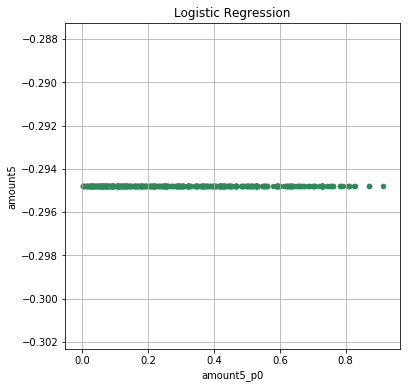

In [625]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',title='Logistic Regression',
                    figsize=(6,6),grid=True,color='seagreen')

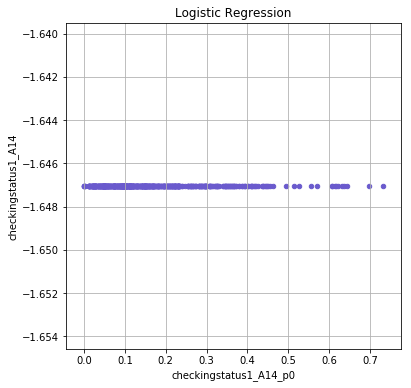

In [626]:
_ = Z.plot.scatter(x='checkingstatus1_A14_p0',y='checkingstatus1_A14',
                   title='Logistic Regression',
                   figsize=(6,6),grid=True,color='slateblue')

In [627]:
Z = perturb(ada,X_train.values,predictors,a0=3200.,a1=6000.)
Z[['amount5','checkingstatus1_A14']].mean()

Perturbation Analysis for model

 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=1000, random_state=18)


amount5               -0.001548
checkingstatus1_A14   -0.020466
dtype: float64

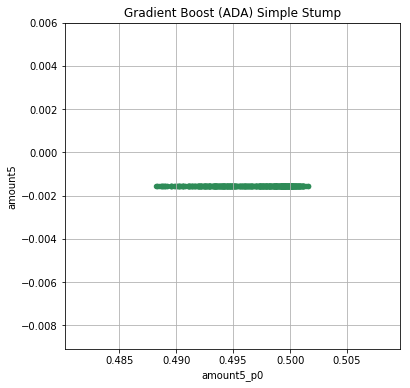

In [628]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',title='Gradient Boost (ADA) Simple Stump',
                    figsize=(6,6),grid=True,color='seagreen')

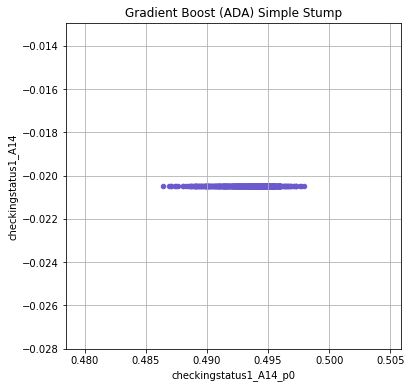

In [629]:
_ = Z.plot.scatter(x='checkingstatus1_A14_p0',y='checkingstatus1_A14',
                   title='Gradient Boost (ADA) Simple Stump',
                   figsize=(6,6),grid=True,color='slateblue')

In [630]:
Z = perturb(grd,X_train.values,predictors,a0=3200.,a1=6000.)
Z[['amount5','checkingstatus1_A14']].mean()

Perturbation Analysis for model

 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=8,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              presort='auto', random_state=18, subsample=0.5, verbose=0,
              warm_start=False)


amount5               -0.422144
checkingstatus1_A14   -1.080730
dtype: float64

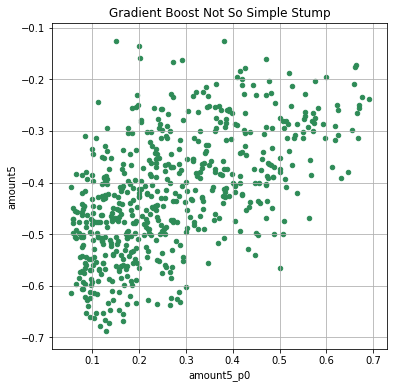

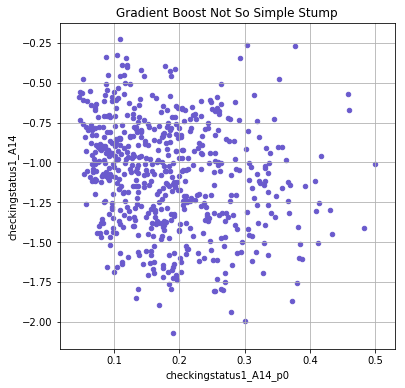

In [631]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',
                   title='Gradient Boost Not So Simple Stump',
                    figsize=(6,6),grid=True,color='seagreen')
_ = Z.plot.scatter(x='checkingstatus1_A14_p0',y='checkingstatus1_A14',
                   title='Gradient Boost Not So Simple Stump',
                   figsize=(6,6),grid=True,color='slateblue')

In [632]:
Z = perturb(dt,X_train.values,predictors,a0=3200.,a1=6000.)
Z[['amount5','checkingstatus1_A14']].mean()

Perturbation Analysis for model

 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=18,
            splitter='best')


amount5               -0.380316
checkingstatus1_A14   -1.920643
dtype: float64

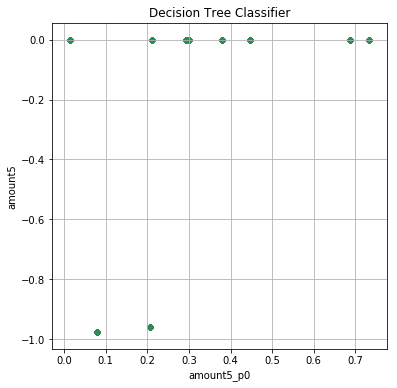

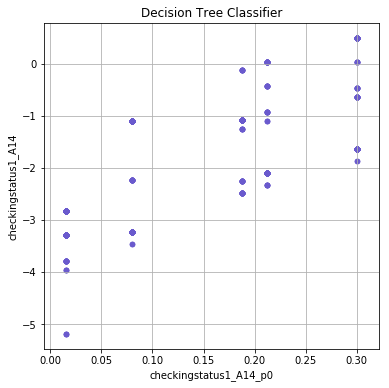

In [633]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',title='Decision Tree Classifier',
                    figsize=(6,6),grid=True,color='seagreen')
_ = Z.plot.scatter(x='checkingstatus1_A14_p0',y='checkingstatus1_A14',
                   title='Decision Tree Classifier',
                   figsize=(6,6),grid=True,color='slateblue')

In [634]:
Z = perturb(rf,X_train.values,predictors,a0=3200.,a1=6000.)
Z[['amount5','checkingstatus1_A14']].mean()

Perturbation Analysis for model

 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=18, verbose=0, warm_start=False)


amount5               -0.153486
checkingstatus1_A14   -0.618018
dtype: float64

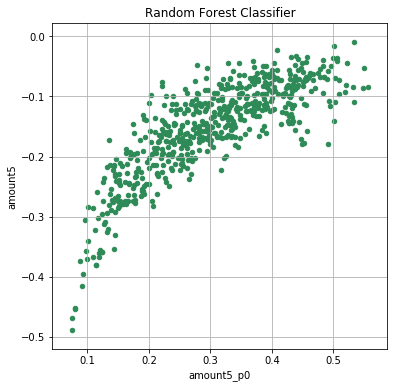

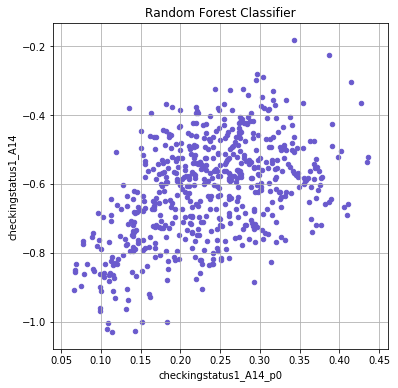

In [635]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',
                   title='Random Forest Classifier',
                   figsize=(6,6),grid=True,color='seagreen')
_ = Z.plot.scatter(x='checkingstatus1_A14_p0',y='checkingstatus1_A14',
                   title='Random Forest Classifier',
                   figsize=(6,6),grid=True,color='slateblue')

## Compare Performance

In [636]:
def perf(y_est,y,delinq_reduce=0.50,revenue_loss=0.1):
    n = len(y)
    bad_total = np.sum(y)
    df = pd.DataFrame({'prob':y_est,'bad':y})
    df = df.sort_values(by='prob').reset_index(drop=True)
    df['cum_bad_pct'] = df.bad.cumsum() / bad_total
    low_delinq_revenue = len(df[df.cum_bad_pct < (1 - delinq_reduce)])/n
    high_rev_delinq = df[df.index.get_values()/n <= (1-revenue_loss)].bad.sum() / bad_total
    
    print('Current Revenue = {:.2%}, Current Delinquency = {:.2%}'.format(1.0, bad_total/n))
    print('Max Revenue While Delinquency is Reduced by {:.2%} = {:.2%}'.format(delinq_reduce,low_delinq_revenue))
    
    print('Min Delinquency If Revenue is Reduced No More Than {:.2%} = {:.2%}'.format(
        revenue_loss,high_rev_delinq))
    return (1,bad_total/n,delinq_reduce,low_delinq_revenue,revenue_loss,high_rev_delinq)

In [637]:
print('Logistic Regression')
tmp = perf(y_pred_prob,y_test)

Logistic Regression
Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 73.43%
Min Delinquency If Revenue is Reduced No More Than 10.00% = 74.14%


In [638]:
print('Machine Learning (Random Forest)')
tmp = perf(y_pred_rf,y_test)

Machine Learning (Random Forest)
Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 75.36%
Min Delinquency If Revenue is Reduced No More Than 10.00% = 75.86%


In [639]:
print('Machine Learning (Neural Network)')
mlp = pd.read_csv('~/Documents/My Samples/germancredit_mlp.csv',header=0)
tmp = perf(mlp.y_est,mlp.y)

Machine Learning (Neural Network)
Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 76.81%
Min Delinquency If Revenue is Reduced No More Than 10.00% = 76.72%


## Setup Optimization

In [640]:
X = np.concatenate([X_train_lr,X_test_lr])
dfout = pd.DataFrame(X,columns=predictors_lr)
dfout['risk'] = logreg.predict_proba(X)[:, 1]
dfout.to_csv('~/Documents/My Samples/germancredit_out.csv',index=False)
dfout.risk.describe()

count    1000.000000
mean        0.309917
std         0.222461
min         0.000322
25%         0.114235
50%         0.270687
75%         0.469657
max         0.903189
Name: risk, dtype: float64